In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
words = list(set(stopwords.words('english')))

from wordcloud import WordCloud, STOPWORDS

In [2]:
class DataFind(object):
    def __init__(self, folder: str):
        self.folder = folder
        
    def get_file_names(self):
        files = [i for i in os.listdir(self.folder)]
        return files

    def get_data(self):
        file_name = DataFind(self.folder).get_file_names()
        db_tweets = pd.DataFrame(columns = ['username', 'acctdesc', 'location', 'following',
                                        'followers', 'totaltweets', 'usercreatedts', 'tweetcreatedts',
                                        'retweetcount', 'text', 'hashtags']
                                )
        for f in file_name:
            if f.endswith('.csv'):
                file_path = os.path.join(self.folder, f)
                df = pd.read_csv(file_path)
                db_tweets = db_tweets.append(df, ignore_index = True)
        return db_tweets
    
    def clean_tweet_data(self, n_grams = 3, stop = True):
        df = DataFind(self.folder).get_data()
        tweets = [word_tokenize(i) for i in df['text']]
        punc = ["~","`","@","?","<",">","=","+","\'", "\"",".",',','!','$','%','^',
                '&','*','(',')','[',']','{','}','\n',' ','  ', ';', '-', '’',':','#']
        tweetss = []
        for t in tweets:
            tweet = []
            for j in t:
                if stop:
                    if j not in words:
                        if not j.startswith('https'):
                            if not j.startswith('//'):
                                for p in punc:
                                    if p in j:
                                        j = j.replace(p,'')
                                tweet.append(j.lower().strip())
                else:
                    if not j.startswith('https'):
                        if not j.startswith('//'):
                            for p in punc:
                                if p in j:
                                    j = j.replace(p,'')
                            tweet.append(j.lower().strip())
            str_list = list(filter(None, tweet))
            tweetss.append([' '.join(str_list[i:i+n_grams]) for i in range(len(str_list)-(n_grams - 1))])
        df['text'] = tweetss
        
        # work on hashtags
        ht = []
        for h in df['hashtags']:
            hashtags = []
            j = h.split(', {')
            for b in j:
                a = b.split(': ')
                if len(a) != 1:
                    hashtags.append(a[1].split(',')[0].replace('\'', '').lower().strip())
                else:
                    hashtags.append('')
            ht.append(hashtags)
        df['hashtags'] = ht
        return df
    
    def freq_plot(self, column = 'text', vals = 10, n_grams = 3):
        data = DataFind(self.folder).clean_tweet_data(n_grams = n_grams)
        if column != 'username':
            all_words = [j for a in data[column] for j in a]
        else:
            all_words = list(data[column])
        
        words_dict = {}
        for a in all_words:
            if a not in words_dict.keys():
                words_dict[a] = 1
            else:
                words_dict[a] += 1
        
        d = pd.DataFrame({'Ngrams':list(words_dict.keys()), 'counts': list(words_dict.values())})
        d = d.sort_values(by = 'counts', ascending = False)
        d = d.iloc[:vals,:]
        
        plt.bar(d['Ngrams'], d['counts'])
        plt.xticks(rotation = -45, ha = 'left')
        plt.title(f"Counts of Twitter {column}")
        
    def make_hist(self, typ = 'sentence', column = 'text', n_grams = 3):
        data = DataFind(self.folder).get_data()
        
        if typ == 'sentence':
            counts = [len(i.split(' ')) for i in data[column]]
        elif typ == 'word':
            counts = [len(list(i)) for i in data[column]]
        
        dic = {}
        for i in counts:
            if i not in list(dic.keys()):
                dic[i] = 1
            else:
                dic[i] += 1
        
        counts = list(dic.values())
        counts = [round(i/max(counts), 2) for i in counts]
        
        plt.hist(counts, bins = 15)
        plt.title(f"Histogram of {typ} length of Twitter {column}")
        
    def wordcloud(self, n_grams = 3, column = 'text'):
        data = DataFind(self.folder).clean_tweet_data(n_grams = n_grams)
        all_words = [str(j.split(' ')[0]) for i in data[column] for j in i]
        wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, stopwords = set(STOPWORDS)).generate(' '.join(all_words))
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.show()
        #plt.savefig(r'Data\Tweets\biden_election\Biden_wordcloud.png')
        

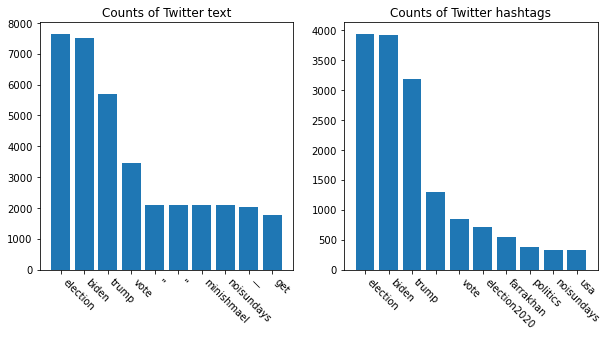

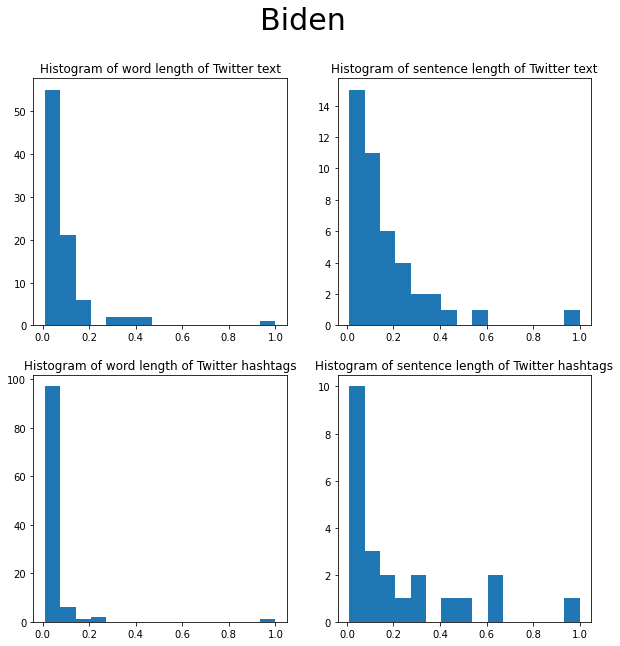

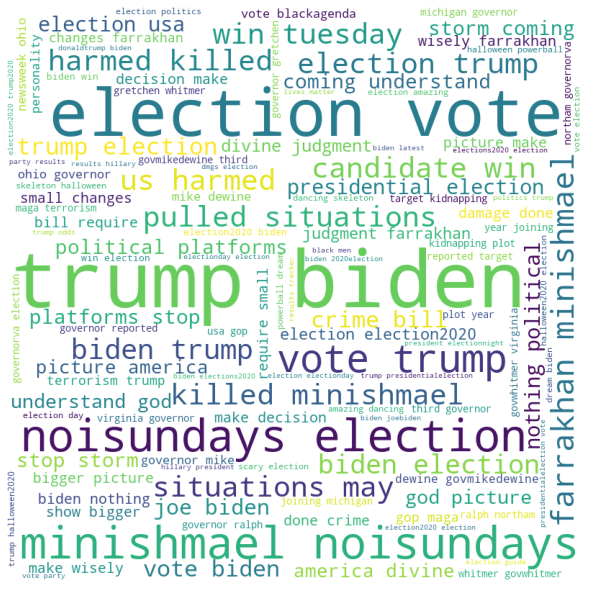

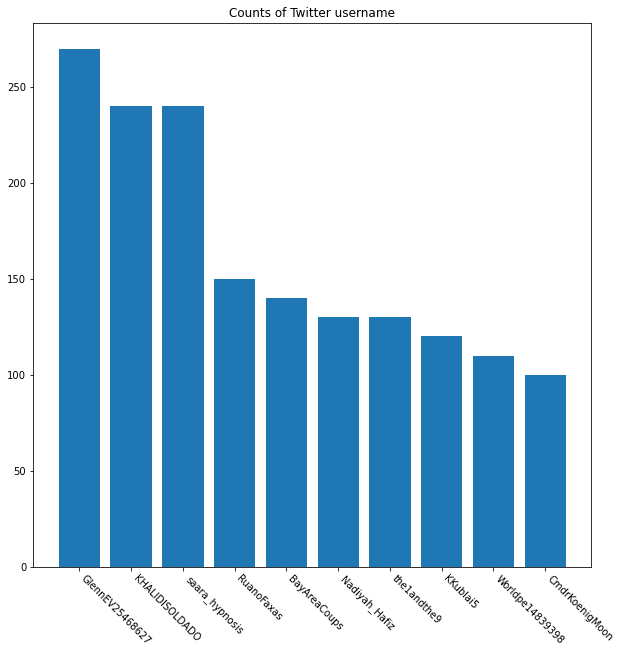

In [3]:
biden_tweet_frame = DataFind(r'Data\Tweets\biden_election')

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
biden_tweet_frame.freq_plot(n_grams = 1, column = 'text')
plt.subplot(2,2,2)
biden_tweet_frame.freq_plot(column = 'hashtags')
plt.savefig(r'Data\Tweets\biden_election\Biden_counts.png')

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
biden_tweet_frame.make_hist(typ = 'word')
plt.subplot(2,2,2)
biden_tweet_frame.make_hist(typ = 'sentence')
plt.subplot(2,2,3)
biden_tweet_frame.make_hist(typ = 'word', column = 'hashtags')
plt.subplot(2,2,4)
biden_tweet_frame.make_hist(typ = 'sentence', column = 'hashtags')
plt.suptitle('Biden', fontsize = 30)
plt.savefig(r'Data\Tweets\biden_election\Biden_histograms.png')

biden_tweet_frame.wordcloud(n_grams = 1, column = 'text')

plt.figure(figsize=(10,10))
biden_tweet_frame.freq_plot(n_grams = 1, column = 'username')

In [4]:
data = biden_tweet_frame.clean_tweet_data()
data = data.dropna(axis = 0, subset = ['location'])
display(data)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
2,RestaurantDive,We provide business journalism and in-depth in...,"Washington, DC",27,864,5668,2018-07-23 21:28:15,2020-10-22 17:39:00,0,"[as 2020 presidential, 2020 presidential race,...","[restaurant, election, biden, trump]"
3,the_rumster1965,"Consultant, asbestos guru, Fire Risk Assessor,...",Devon England,9225,8390,35840,2011-11-24 14:08:00,2020-10-22 17:37:17,2,"[joe biden gone, biden gone hiding, gone hidin...",[]
5,Cone_of_power,Big cuddly Ram. RT's not endorsed. Dislike mos...,Cafe Benidorm (I wish),4999,2570,36802,2012-05-22 13:46:22,2020-10-22 17:22:34,2,"[joe biden gone, biden gone hiding, gone hidin...",[]
6,SuperSySez,Unscripted social commentary/satire in 60 seco...,Tattoine - Far Far away,1650,1627,19840,2017-07-16 16:46:24,2020-10-22 17:20:27,2,"[joe biden gone, biden gone hiding, gone hidin...","[election2020, biden, trump, election]"
7,yoooJonny,@SouthPark stan. | college grad. #registeredin...,U S of A,50,4,38,2020-05-29 18:06:31,2020-10-22 16:49:34,0,"[the media show, media show they, show they sa...","[mainstreammedia, elections, election2020, ele..."
...,...,...,...,...,...,...,...,...,...,...,...
6394,SteveKlinko,"Fulltime Electronics and Software Engineer, Ph...","Titusville, FL",4975,1277,49832,2016-04-30 14:17:05,2020-11-01 18:57:18,0,"[search sympathy for, sympathy for the, for th...","[trump, biden, election, politics]"
6395,MaximDShrayer,"Bilingual author and translator. ""Waiting for ...","Boston, MA",325,182,248,2018-01-19 01:10:14,2020-11-01 18:53:26,0,"[jewish wolves united, wolves united trump, un...","[wolfmovie, trump2020, wolf, halloween2020, ha..."
6396,saara_hypnosis,NaN,Everywhere,984,327,34226,2009-07-09 20:37:07,2020-11-01 18:48:24,28,"[“ the damage, the damage done, damage done 19...","[farrakhan, noisundays]"
6398,saara_hypnosis,NaN,Everywhere,984,327,34226,2009-07-09 20:37:07,2020-11-01 18:44:45,24,"[“ nothing political, nothing political platfo...",[]
